# Mensa data analysis

### Import requests:

In [325]:
import pandas as pd
import  matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar


### load data

I have one .csv from my Bachelor and one for the Master (different card).

In [326]:
#df1 = pd.read_csv('mensascrape_BA.csv')
df2 = pd.read_csv('mensascrape.csv')
#df1['index']=df1['index']+max(df2['index'])
#df = pd.concat([df2,df1])
df = df2

### Data Cleanup

In [327]:
df = df.drop('Unnamed: 0',axis=1)
df["Datum"] = pd.to_datetime(df["Datum"],format="%d.%m.%Y %H:%M")
Full_df_copy = df  #copy might use later
df['Monat'] = df["Datum"].dt.month
df['Weekday'] = df["Datum"].dt.weekday
df['Weekday_abbr'] = df["Weekday"].apply(lambda x: calendar.day_abbr[x])
df['Monat_abbr'] = df['Monat'].apply(lambda x: calendar.month_abbr[x])
n_transactions = max(df['index'])+1
df['Betrag [€]'] = df['Betrag'].str.replace('€','').astype(float)
df = df.drop(['Rabatt','Bonus','PDF','Bon-Nr.'],axis=1) #no need

### Data Visualization

#### Overview:

In [328]:
td = df["Datum"].max()-df["Datum"].min() #complete timeframe as timedelta
print('All transactions found from ' +str(df["Datum"].min().strftime("%d.%m.%Y")) +' to '+ str(df["Datum"].max().strftime("%d.%m.%Y"))+':   '+str(n_transactions))
print('That makes roughly '+str(round((7/5)*n_transactions/td.days,1))+' transactions per weekday!! (not considering holidays)')

All transactions found from 02.11.2021 to 30.05.2022:   190
That makes roughly 1.3 transactions per weekday!! (not considering holidays)


Mate consuption:

Mate: 38 vs. 38 Kaffee


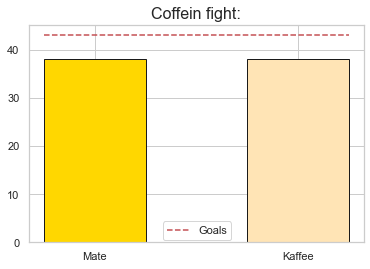

In [329]:
n_mate = df[df['Artikel'].str.contains('Mate')]['index'].nunique()
n_kaffee = df[df['Artikel'].str.contains('Kaffee|Cappuccino|Caffe')]['index'].nunique()
print('Mate: '+str(n_mate)+' vs. '+str(n_kaffee)+' Kaffee')
fig, ax = plt.subplots()
threshold = max(n_kaffee,n_mate)+5
ax.bar(['Mate','Kaffee'],[n_mate,n_kaffee],[0.5,0.5], color=['gold','moccasin'],edgecolor = ['k','k'])
ax.plot([-0.25, 1.25], [threshold, threshold], "r--",label='Goals')
leg = plt.legend(loc=(0.4,0.01))
plt.title('Coffein fight:',fontsize = 16)
plt.show()

#### koeri-share:

In [330]:
n_transactions = df['index'].nunique()
n_koeri = df[df['Kasse'].str.contains("koeri")]['index'].nunique()
n_cafete = df[df['Kasse'].str.contains("Cafeteria")]['index'].nunique()
n_mensa = n_transactions-n_cafete
print('You are '+str(round(100*n_koeri/n_mensa,2))+'% pure [koeri]')
print('Imagine what 100% would feel like...')

You are 38.02% pure [koeri]
Imagine what 100% would feel like...


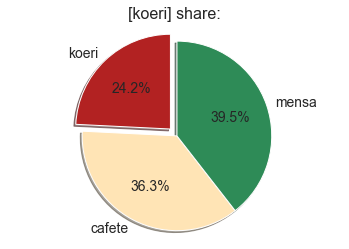

In [331]:
labels = 'koeri', 'cafete', 'mensa'
sizes = [n_koeri,n_cafete,n_transactions-n_koeri-n_cafete]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=['firebrick','moccasin','seagreen'], autopct='%1.1f%%', shadow=True, startangle=90,textprops={'fontsize': 14})
ax1.axis('equal')
plt.title('[koeri] share:',fontsize = 16)
plt.show()

further Data cleanup 

In [332]:
df[df['Typ'].str.contains('Verkauf')]['index'].unique()
df_kauf = df[df['Typ'].str.contains('Verkauf')]
df_mensa = df_kauf[~df_kauf['Kasse'].str.contains("Cafeteria|Chicco")]
df_mensa = df_mensa.drop_duplicates(subset='index')
df_mensa['Betrag [€]'] = df_mensa['Betrag [€]'].abs()


Mensa day:

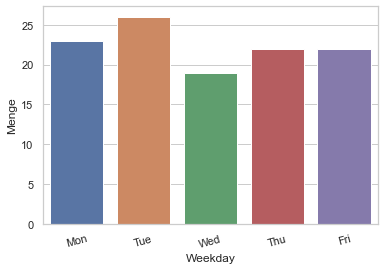

Your mensa day #1 is: Tue


In [363]:
df_mensa_day = df_mensa.groupby(pd.Grouper('Weekday_abbr'), as_index=False).sum()
Days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
ax = sns.barplot(x='Weekday_abbr', y='Menge' , data=df_mensa_day, order=Days)
ax.set_xlabel("Weekday")
ax.set(title='')
plt.xticks(rotation=15)
plt.show(fig); 
print('Your mensa day #1 is: '+df_mensa_day.iloc[df_mensa_day['Menge'].idxmax(),0])

Average price for mensa meal:

In [334]:
avg_price = round(abs(df_mensa['Betrag [€]'].mean()),2)
print(str(avg_price)+' €')

3.81 €


plot for price per mensa meal over time:

[Text(0.5, 1.0, 'Avg. meal price over time')]

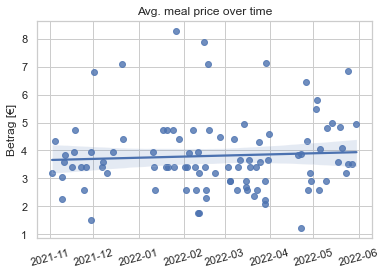

In [335]:
x = df_mensa['Datum']
y = df_mensa["Betrag [€]"]
f, ax = plt.subplots()
ax.xaxis.update_units(x)
plt.xticks(rotation=15)
sns.regplot(x=ax.xaxis.convert_units(x), y=y).set(title='Avg. meal price over time')

plot for price per mensa meal over time: <br>
But without outliers

[Text(0.5, 1.0, 'Avg. meal price over time (w/outliers)')]

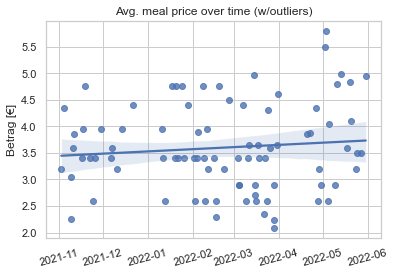

In [336]:
df_clean = df_mensa[np.abs(df_mensa['Betrag [€]']-df_mensa['Betrag [€]'].mean()) <= (1.5*df_mensa['Betrag [€]'].std())]
x = df_clean['Datum']
y = df_clean["Betrag [€]"]
f, ax = plt.subplots()
ax.xaxis.update_units(x)
plt.xticks(rotation=15)
sns.regplot(x=ax.xaxis.convert_units(x), y=y).set(title='Avg. meal price over time (w/outliers)')

Monthly spendings for mensa meals over time:

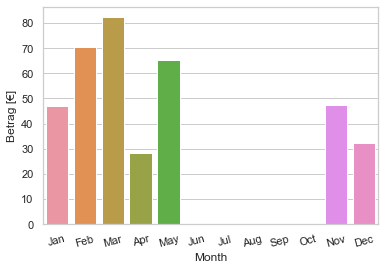

In [337]:
df_mensa_month = df_mensa.groupby(pd.Grouper('Monat_abbr'), as_index=False).sum()
Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax = sns.barplot(x='Monat_abbr', y='Betrag [€]' , data=df_mensa_month, order=Months)
ax.set_xlabel("Month")
plt.xticks(rotation=15)
plt.show(fig); 